# **Modelling and Evaluation Notebook**

## Objectives

* Engineer features for modelling
* Perform data classification of cherry leaf into healthy or powdery mildew leaf

## Inputs

* inputs/dataset/raw/cherry-leaves/test
* inputs/dataset/raw/cherry-leaves/train
* inputs/dataset/raw/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file


---

# Change working directory

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

## Set Data directories

### Set Input Directory

Define data path of the train, test and validation datasets.

In [5]:
root_data_dir = 'inputs/datasets/raw/cherry-leaves'
train_dir = os.path.join(root_data_dir, 'train')
test_dir = os.path.join(root_data_dir, 'test')
validation_dir = os.path.join(root_data_dir, 'validation')


### Set ouput directory

In [6]:
version = 'v1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1 already exists. Create a new version


### Set label names

In [7]:
# Set the labels
labels = os.listdir(train_dir)
print('Label for the images are',labels)

Label for the images are ['healthy', 'powdery_mildew']


### Set Image shape

Import image shape saved in data visualization notebook

In [8]:
import joblib

version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pk1")
image_shape

(100, 100, 3)

---

### Explore the number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




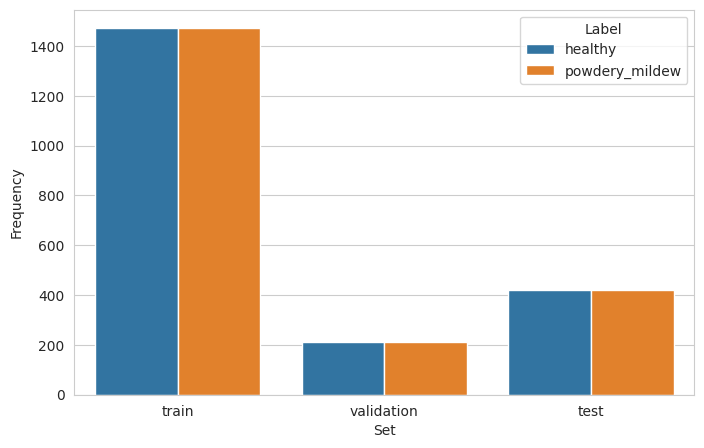

In [9]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    label_data = os.listdir(root_data_dir+'/'+ folder + '/' + label)
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(label_data))
                        }), ignore_index=True)
    
    print(f"* {folder} - {label}: {len(label_data)} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

From the plot above it is seen that the train dataset for both the healthy and powdery mildew dataset are 1472 images each. This isn't large enough for deep learning model as a result the size of dataset is increased with image augmentation

### Define some parameters for the loader

In [10]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

### ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialize ImageDataGenerator

In [12]:
augmented_data = ImageDataGenerator(
                                   rotation_range=20,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Augment training image dataset

In [13]:
train_set = augmented_data.flow_from_directory(train_dir,
                                              target_size=image_shape[:2],
                                              color_mode=data_color_mode,
                                              batch_size=batch_size,
                                              class_mode=data_class_mode,
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir,
                                                          target_size=image_shape[:2],
                                                          color_mode=data_color_mode,
                                                          batch_size=batch_size,
                                                          class_mode=data_class_mode,
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                    target_size=image_shape[:2],
                                                    color_mode=data_color_mode,
                                                    batch_size=batch_size,
                                                    class_mode=data_class_mode,
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image

In [17]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()

#### plot train set

(32, 100, 100, 3)


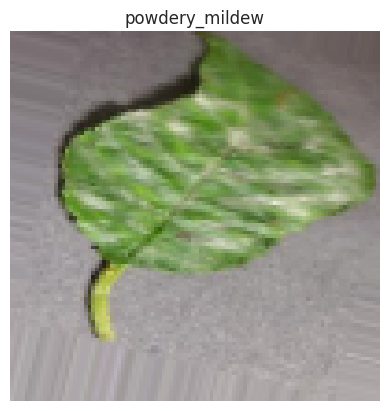

(32, 100, 100, 3)


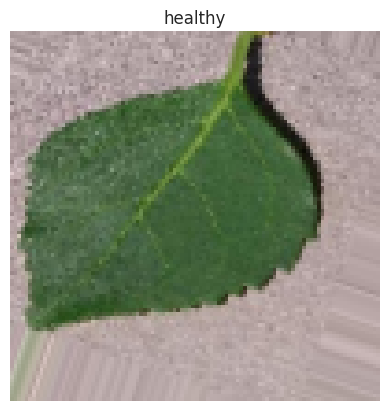

(32, 100, 100, 3)


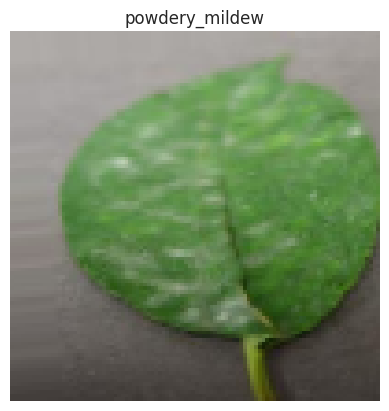

In [18]:
plot_augmented_image(train_set)

#### plot validation set

(32, 100, 100, 3)


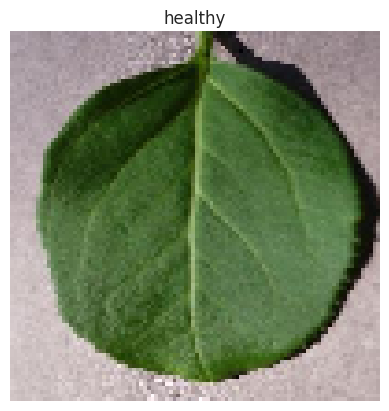

(32, 100, 100, 3)


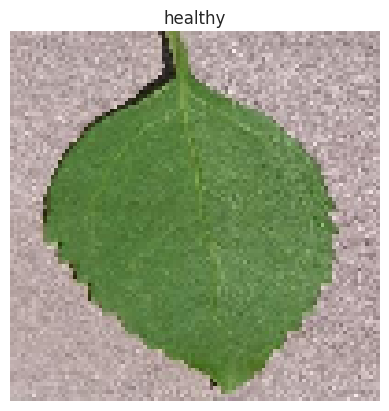

(32, 100, 100, 3)


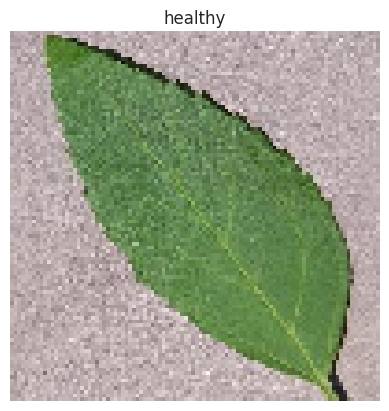

In [19]:
plot_augmented_image(validation_set)

#### plot test set images

(32, 100, 100, 3)


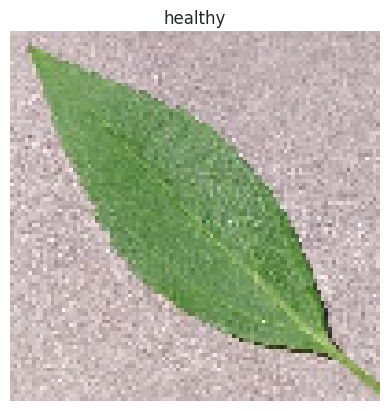

(32, 100, 100, 3)


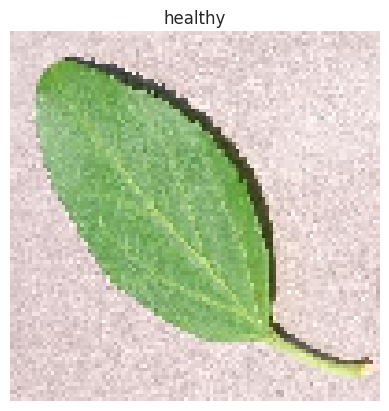

(32, 100, 100, 3)


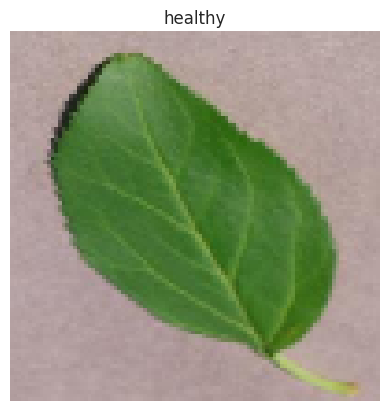

In [20]:
plot_augmented_image(test_set)

### Save class_indices

In [21]:
joblib.dump(value=train_set.class_indices, 
            filename = f'{file_path}/class_indices.pkl')

['outputs/v1/class_indices.pkl']

---

## Model Creation

The modelused is the Convolutional Neural Network (CNN) which will learn from the dorminant feature (the powdery mildew) of the pre-labeled cherry leaf image.

### ML Model

Import model packages

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

define parameters

In [51]:
EPOCHS = 15
OUTPUT_DIR = 'outputs/v1'

Create Model

In [52]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=4, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model


#### Model Summary

In [53]:
create_model().summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 47, 47, 8)         584       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 23, 23, 8)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 21, 21, 4)         292       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 10, 10, 4)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 400)             

#### Model Network Architecture

#### Early stopping

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [47]:
 len(train_set.classes) // batch_size

92

### Fit model for model training

In [54]:
model = create_model()
model.fit(train_set,
          epochs=EPOCHS,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data = validation_set,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/15
92/92 [==============================] - 10s 106ms/step - loss: 0.4623 - accuracy: 0.7765 - val_loss: 0.2410 - val_accuracy: 0.9000
Epoch 2/15
92/92 [==============================] - 9s 93ms/step - loss: 0.2795 - accuracy: 0.8927 - val_loss: 0.1892 - val_accuracy: 0.9405
Epoch 3/15
92/92 [==============================] - 14s 155ms/step - loss: 0.2016 - accuracy: 0.9293 - val_loss: 0.1014 - val_accuracy: 0.9619
Epoch 4/15
92/92 [==============================] - 8s 89ms/step - loss: 0.1316 - accuracy: 0.9531 - val_loss: 0.0588 - val_accuracy: 0.9810
Epoch 5/15
92/92 [==============================] - 10s 106ms/step - loss: 0.1009 - accuracy: 0.9650 - val_loss: 0.0632 - val_accuracy: 0.9810
Epoch 6/15
92/92 [==============================] - 15s 158ms/step - loss: 0.0909 - accuracy: 0.9728 - val_loss: 0.0726 - val_accuracy: 0.9810
Epoch 7/15
92/92 [==============================] - 14s 148ms/step - loss: 0.0776 - accuracy: 0.9772 - val_loss: 0.0251 - val_accuracy: 0.9952
Epo

### Save model

In [56]:
model.save(f'{OUTPUT_DIR}/mildew_detector_model.h5')

## Model Performance

### Model Learning Curve

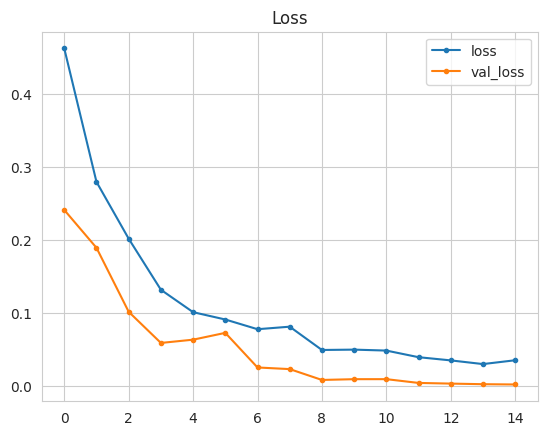

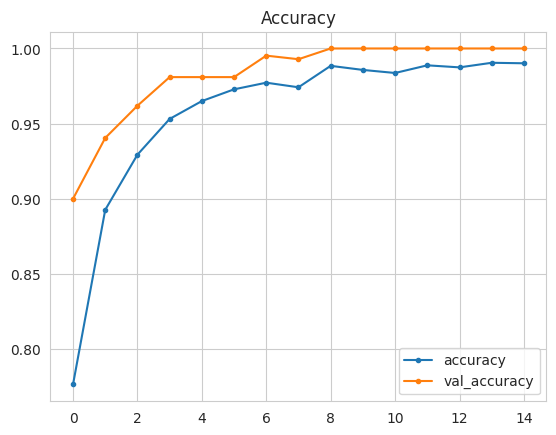

In [55]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

In [57]:
from keras.models import load_model
model = load_model(f'{OUTPUT_DIR}/mildew_detector_model.h5')

Evaluate model on test set

In [58]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 2s 61ms/step - loss: 0.0043 - accuracy: 0.9988


Save evaluation pickle

In [59]:
joblib.dump(value=evaluation, filename=f'{OUTPUT_DIR}/evaluation.pk1')

['outputs/v1/evaluation.pk1']

### Predict on new data

Image shape: (100, 100), Image mode: RGB


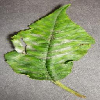

In [60]:
from tensorflow.keras.preprocessing import image

pointer = 80
label = labels[1] # select from the powdery mildew leaf
img = os.listdir(f'{test_dir}/{label}')[pointer]
file_to_load = os.path.join(test_dir, label, img)

pil_image = image.load_img(file_to_load, target_size = image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array for prediction

In [61]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


Predict class probabilities

In [62]:
prediction_probability = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
predicted_class =  target_map[prediction_probability > 0.5]  

if predicted_class == target_map[0]: prediction_probability = 1 - prediction_probability

print(f'Prediction probability: {prediction_probability}')
print(f'Predicted class: {predicted_class}')


Prediction probability: 0.9999996423721313
Predicted class: powdery_mildew


---

## Push files to repo

- .gitignore

In [ ]:
!cat .gitignore

- git status

In [ ]:
!git status

- git add

In [ ]:
!git add .

- git commit

In [ ]:
!git commit 